## Parameters

In [ ]:
import os
import argparse

import torch

def build_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument('--gpu-no', type=int,
                    help='cpu: -1, gpu: 0 ~ n ', default=0)

    parser.add_argument('--train-flag', action='store_true',
                    help='flag for training  network', default=False)

    parser.add_argument('--resume-flag', action='store_true',
                    help='flag for resume training', default=False)

    parser.add_argument('--prune-flag',action='store_true',
                    help='flag for pruning network', default=False)

    parser.add_argument('--retrain-flag',action='store_true',
                    help='flag for retraining pruned network', default=False)

    parser.add_argument('--retrain-epoch',type=int,
                    help='number of epoch for retraining pruned network', default=20)

    parser.add_argument('--retrain-lr',type=float,
                    help='learning rate for retraining pruned network', default=0.001)

    parser.add_argument('--data-set', type=str,
                    help='Data set for training network', default='CIFAR10')

    parser.add_argument('--data-path', type=str,
                    help='Path of dataset', default='../')

    parser.add_argument('--vgg', type=str,
                    help='version of vgg network', default='vgg16_bn')
    
    parser.add_argument('--start-epoch', type=int,
                    help='start epoch for training network', default=0)

    parser.add_argument('--epoch', type=int,
                    help='number of epoch for training network', default=350)
    
    parser.add_argument('--batch-size', type=int,
                    help='batch size', default=128)

    parser.add_argument('--num-workers', type=int,
                    help='number of workers for data loader', default=2)

    parser.add_argument('--lr', type=float,
                    help='learning rate', default=0.1)

    parser.add_argument('--lr-milestone', type=list,
                    help='list of epoch for adjust learning rate', default=[150, 250])

    parser.add_argument('--lr-gamma', type=float,
                    help='factor for decay learning rate', default=0.1)

    parser.add_argument('--momentum', type=float,
                    help='momentum for optimizer', default=0.9)

    parser.add_argument('--weight-decay', type=float,
                    help='factor for weight decay in optimizer', default=5e-4)

    parser.add_argument('--imsize', type=int,
                    help='size for image resize', default=None)

    parser.add_argument('--cropsize', type=int,
                    help='size for image crop', default=32)

    parser.add_argument('--crop-padding', type=int,
                    help='size for padding in image crop', default=4)

    parser.add_argument('--hflip', type=float,
                    help='probability of random horizontal flip', default=0.5)

    parser.add_argument('--print-freq', type=int,
                    help='print frequency during training', default=100)

    parser.add_argument('--load-path', type=str,
                    help='trained model load path to prune', default=None)

    parser.add_argument('--save-path',type=str,
                    help='model save path', required=True)

    parser.add_argument('--independent-prune-flag', action='store_true',
                    help='prune multiple layers by "independent strategy"', default=False)

    parser.add_argument('--prune-layers', nargs='+',
                    help='layer index for pruning', default=None)

    parser.add_argument('--prune-channels', nargs='+', type=int,
                    help='number of channel to prune layers', default=None)


    return parser

def get_parameter():
    parser = build_parser()
    args = parser.parse_args()
    os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_no)
    
    print("-*-"*10 + "\n\tArguments\n" + "-*-"*10)
    for key,value in vars(args).items():
        print("%s: %s"%(key, value))

    if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)
        print("Make dir: ",args.save_path)

    torch.save(args, args.save_path+"arguments.pth")

    return args

## Network

In [ ]:
import torch
import torchvision.models as models

class VGG(torch.nn.Module):
    def __init__(self, vgg='vgg16_bn', data_set='CIFAR10', pretrained=False):
        super(VGG, self).__init__()
        self.features = models.__dict__[vgg](pretrained=pretrained).features
        
        classifier = []
        if 'CIFAR' in data_set:
            num_class = int(data_set.split("CIFAR")[1])
            
            classifier.append(torch.nn.Linear(512, 512))
            classifier.append(torch.nn.BatchNorm1d(512))
            classifier.append(torch.nn.Linear(512, num_class))
        else:
            raise RuntimeError("Not expected data flag !!!")

        self.classifier = torch.nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Optimizer

In [ ]:
import torch

def get_optimizer(network, args):
    optimizer = torch.optim.SGD(network.parameters(),
                                lr=args.lr, 
                                momentum=args.momentum, 
                                weight_decay=args.weight_decay)    

    scheduler = None
    if args.lr_milestone is not None:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.lr_milestone, gamma=args.lr_gamma)

    return optimizer, scheduler

## Loss Calculation

In [ ]:
class Loss_Calculator(object):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()        
        self.loss_seq = []
    
    def calc_loss(self, output, target):
        loss = self.criterion(output, target)        
        self.loss_seq.append(loss.item())
        return loss

    def get_loss_log(self, length=100):
        # get recent average loss values
        if len(self.loss_seq) < length:
            length = len(self.loss_seq)
        return sum(self.loss_seq[-length:])/length

## Utils

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

class AverageMeter(object):    
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_normalizer(data_set, inverse=False):
    if data_set == 'CIFAR10':
        MEAN = (0.4914, 0.4822, 0.4465)
        STD = (0.2023, 0.1994, 0.2010)

    else:
        raise RuntimeError("Not expected data flag !!!")

    if inverse:
        MEAN = [-mean/std for mean, std in zip(MEAN, STD)]
        STD = [1/std for std in STD]

    return transforms.Normalize(MEAN, STD)

def get_transformer(data_set, imsize=None, cropsize=None, crop_padding=None, hflip=None):
    transformers = [] 
    if imsize:
        transformers.append(transforms.Resize(imsize))
    if cropsize:
        ## https://github.com/kuangliu/pytorch-cifar
        transformers.append(transforms.RandomCrop(cropsize, padding=crop_padding))
    if hflip:
        transformers.append(transforms.RandomHorizontalFlip(hflip))

    transformers.append(transforms.ToTensor())
    transformers.append(get_normalizer(data_set))
    
    return transforms.Compose(transformers)

def get_data_set(args, train_flag=True):
    if train_flag:
        data_set = torchvision.datasets.__dict__[args.data_set](root=args.data_path, train=True, 
                                       transform=get_transformer(args.data_set, args.imsize,
                                           args.cropsize, args.crop_padding, args.hflip), download=True)
    else:
        data_set = torchvision.datasets.__dict__[args.data_set](root=args.data_path, train=False, 
                                           transform=get_transformer(args.data_set), download=True)    
    return data_set


## Train



In [ ]:
from torchsummary import summary

def train_network(args, network=None, data_set=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")

    if network is None:
        network = VGG(args.vgg, args.data_set)
    network = network.to(device)

    summary(network, (3, 32, 32))
    print(network)

    if data_set is None:
        data_set = get_data_set(args, train_flag=True)
    
    loss_calculator = Loss_Calculator()
    
    optimizer, scheduler = get_optimizer(network, args)
    
    if args.resume_flag:
        check_point = torch.load(args.load_path)
        network.load_state_dict(check_point['state_dict'])
        loss_calculator.loss_seq = check_point['loss_seq']
        args.start_epoch = check_point['epoch'] # update start epoch
                
    print("-*-"*10 + "\n\tTrain network\n" + "-*-"*10)
    for epoch in range(args.start_epoch, args.epoch):
        # make shuffled data loader
        data_loader = torch.utils.data.DataLoader(data_set, batch_size=args.batch_size, shuffle=True)

        # train one epoch
        train_step(network, data_loader, loss_calculator, optimizer, device, epoch, args.print_freq)

        # adjust learning rate
        if scheduler is not None:
            scheduler.step()

        torch.save({'epoch': epoch+1, 
                   'state_dict': network.state_dict(),
                   'loss_seq': loss_calculator.loss_seq},
                   args.save_path+"check_point.pth")
        
    return network

def train_step(network, data_loader, loss_calculator, optimizer, device, epoch, print_freq=100):
    network.train()
    # set benchmark flag to faster runtime
    torch.backends.cudnn.benchmark = True
        
    data_time = AverageMeter()
    loss_time = AverageMeter()    
    forward_time = AverageMeter()
    backward_time = AverageMeter()
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    tic = time.time()
    for iteration, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - tic)
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        tic = time.time()
        outputs = network(inputs)
        forward_time.update(time.time() - tic)
        
        tic = time.time()
        loss = loss_calculator.calc_loss(outputs, targets)
        loss_time.update(time.time() - tic)
        
        tic = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time.update(time.time() - tic)
        
        prec1, prec5 = accuracy(outputs.data, targets, topk=(1,5))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))
                        
        if iteration % print_freq == 0:
            logs_ = '%s: '%time.ctime()
            logs_ += 'Epoch [%d], '%epoch
            logs_ += 'Iteration [%d/%d/], '%(iteration, len(data_loader))
            logs_ += 'Data(s): %2.3f, Loss(s): %2.3f, '%(data_time.avg, loss_time.avg)
            logs_ += 'Forward(s): %2.3f, Backward(s): %2.3f, '%(forward_time.avg, backward_time.avg)
            logs_ += 'Top1: %2.3f, Top5: %2.4f, '%(top1.avg, top5.avg)
            logs_ += 'Loss: %2.3f'%loss_calculator.get_loss_log()
            print(logs_)            
                        
        tic = time.time()
    return None

## Evaluation

In [ ]:
import time

import torch

from torchsummary import summary

# from network import VGG
# from utils import AverageMeter, get_data_set

def test_network(args, network=None, data_set=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")

    # summary(network, (3, 32, 32))
    # print(network)
    
    if network is None:
        network = VGG(args.vgg, args.data_set)
        if args.load_path:
            check_point = torch.load(args.load_path)
            network.load_state_dict(check_point['state_dict'])
    network.to(device)

    if data_set is None:
        data_set = get_data_set(args, train_flag=False)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=100, shuffle=False)

    top1, top5 = test_step(network, data_loader, device)
    
    return network, data_set, (top1, top5)
    
def test_step(network, data_loader, device):
    network.eval()
        
    data_time = AverageMeter()
    forward_time = AverageMeter()    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    with torch.no_grad():
        tic = time.time()
        for inputs, targets in data_loader:
            data_time.update(time.time() - tic)

            inputs, targets = inputs.to(device), targets.to(device)
            
            tic = time.time()
            outputs = network(inputs)
            forward_time.update(time.time() - tic)
            
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            tic = time.time()

    str_ = '%s: Test information, '%time.ctime()
    str_ += 'Data(s): %2.3f, Forward(s): %2.3f, '%(data_time.sum, forward_time.sum)
    str_ += 'Top1: %2.3f, Top5: %2.3f, '%(top1.avg, top5.avg)
    print("-*-"*10 + "\n\tEvalute network\n" + "-*-"*10)
    print(str_)
    
    return top1.avg, top5.avg

def accuracy(output, target, topk=(1,)):
    """
        Computes the precision@k for the specified values of k
        ref: https://github.com/chengyangfu/pytorch-vgg-cifar10
    """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

## Test Image

In [ ]:
import time
import torch
from torchsummary import summary
from scipy import misc
import imageio
from PIL import Image
import numpy as np

label = ["airplane" , "automobile", "bird", "cat", "deer", "dog", "frog" , "horse", "ship", "truck"]

def image_network(args,image , network=None, data_set=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")
    
    # print(summary(network, (3, 32, 32)))
    print(network)
    if network is None:
        network = VGG(args.vgg, args.data_set)
        if args.load_path:
            check_point = torch.load(args.load_path)
            network.load_state_dict(check_point['state_dict'])
    network.to(device)

    output = test_step(network, image , device)
    print("Class : "+ label[np.argmax(output)])

    
def test_step(network, image, device):
    network.eval()
        
    data_time = AverageMeter()
    forward_time = AverageMeter()    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    with torch.no_grad():
        
        # test_image = misc.imread(image)
        # test_image = imageio.imread(image)

        # tlabel = label.to(device)

        image = Image.open(image)
        test_image = image.resize((32, 32),Image.ANTIALIAS)

        test_image = np.asarray(test_image)
        tensor = torch.from_numpy(test_image).float()

        reshaped = tensor.permute(2, 0, 1).unsqueeze(0)
        
        tic = time.time()
        data_time.update(time.time() - tic)

        reshaped = reshaped.to(device)
        
        tic = time.time()
        output = network(reshaped)
        # print(output)
        forward_time.update(time.time() - tic)

        index = output.cpu().data.numpy().argmax()
        
        tic = time.time()
    str_ = '%s: Test information, '%time.ctime()
    str_ += 'Data(s): %2.3f, Forward(s): %2.3f, '%(data_time.sum, forward_time.sum)
    # str_ += 'Top1: %2.3f, Top5: %2.3f, '%(top1.avg, top5.avg)
    print("-*-"*10 + "\n\tEvalute network\n" + "-*-"*10)
    print(str_)

    return index

## Prune

In [ ]:
def prune_network(args, network=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")

    if network is None:
        network = VGG(args.vgg, args.data_set)
        if args.load_path:
            check_point = torch.load(args.load_path)
            network.load_state_dict(check_point['state_dict'])

    # prune network
    network = prune_step(network, args.prune_layers, args.prune_channels, args.independent_prune_flag)
    network = network.to(device)
    print("-*-"*10 + "\n\tPrune network\n" + "-*-"*10)
    print(network)

    if args.retrain_flag:
        # update arguemtns for retraing pruned network
        args.epoch = args.retrain_epoch
        args.lr = args.retrain_lr
        args.lr_milestone = None # don't decay learning rate

        network = train_network(args, network)

    return network

def prune_step(network, prune_layers, prune_channels, independent_prune_flag):
    network = network.cpu()

    count = 0 # count for indexing 'prune_channels'
    conv_count = 1 # conv count for 'indexing_prune_layers'
    dim = 0 # 0: prune corresponding dim of filter weight [out_ch, in_ch, k1, k2]
    residue = None # residue is need to prune by 'independent strategy'
    for i in range(len(network.features)):
        if isinstance(network.features[i], torch.nn.Conv2d):
            if dim == 1:
                new_, residue = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                network.features[i] = new_
                dim ^= 1

            if 'conv%d'%conv_count in prune_layers:         
                channel_index = get_channel_index(network.features[i].weight.data, prune_channels[count], residue)
                new_ = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                network.features[i] = new_
                dim ^= 1
                count += 1
            else:
                residue = None
            conv_count += 1

        elif dim == 1 and isinstance(network.features[i], torch.nn.BatchNorm2d):
            new_ = get_new_norm(network.features[i], channel_index)
            network.features[i] = new_

    # update to check last conv layer pruned
    if 'conv13' in prune_layers:
        network.classifier[0] = get_new_linear(network.classifier[0], channel_index)

    return network

def get_channel_index(kernel, num_elimination, residue=None):
    # get cadidate channel index for pruning
    ## 'residue' is needed for pruning by 'independent strategy'

    sum_of_kernel = torch.sum(torch.abs(kernel.view(kernel.size(0), -1)), dim=1)
    if residue is not None:
        sum_of_kernel += torch.sum(torch.abs(residue.view(residue.size(0), -1)), dim=1)
    
    vals, args = torch.sort(sum_of_kernel)

    return args[:num_elimination].tolist()

def index_remove(tensor, dim, index, removed=False):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    size_ = list(tensor.size())
    new_size = tensor.size(dim) - len(index)
    size_[dim] = new_size
    new_size = size_

    select_index = list(set(range(tensor.size(dim))) - set(index))
    new_tensor = torch.index_select(tensor, dim, torch.tensor(select_index))
    
    if removed:
        return new_tensor, torch.index_select(tensor, dim, torch.tensor(index))

    return new_tensor

def get_new_conv(conv, dim, channel_index, independent_prune_flag=False):
    if dim == 0:
        new_conv = torch.nn.Conv2d(in_channels=conv.in_channels,
                                   out_channels=int(conv.out_channels - len(channel_index)),
                                   kernel_size=conv.kernel_size,
                                   stride=conv.stride, padding=conv.padding, dilation=conv.dilation)
        
        new_conv.weight.data = index_remove(conv.weight.data, dim, channel_index)
        new_conv.bias.data = index_remove(conv.bias.data, dim, channel_index)

        return new_conv

    elif dim == 1:
        new_conv = torch.nn.Conv2d(in_channels=int(conv.in_channels - len(channel_index)),
                                   out_channels=conv.out_channels,
                                   kernel_size=conv.kernel_size,
                                   stride=conv.stride, padding=conv.padding, dilation=conv.dilation)
        
        new_weight = index_remove(conv.weight.data, dim, channel_index, independent_prune_flag)
        residue = None
        if independent_prune_flag:
            new_weight, residue = new_weight
        new_conv.weight.data = new_weight
        new_conv.bias.data = conv.bias.data

        return new_conv, residue

def get_new_norm(norm, channel_index):
    new_norm = torch.nn.BatchNorm2d(num_features=int(norm.num_features - len(channel_index)),
                                    eps=norm.eps,
                                    momentum=norm.momentum,
                                    affine=norm.affine,
                                    track_running_stats=norm.track_running_stats)

    new_norm.weight.data = index_remove(norm.weight.data, 0, channel_index)
    new_norm.bias.data = index_remove(norm.bias.data, 0, channel_index)

    if norm.track_running_stats:
        new_norm.running_mean.data = index_remove(norm.running_mean.data, 0, channel_index)
        new_norm.running_var.data = index_remove(norm.running_var.data, 0, channel_index)
        
    return new_norm

def get_new_linear(linear, channel_index):
    new_linear = torch.nn.Linear(in_features=int(linear.in_features - len(channel_index)),
                                out_features=linear.out_features,
                                bias=linear.bias is not None)
    new_linear.weight.data = index_remove(linear.weight.data, 1, channel_index)
    new_linear.bias.data = linear.bias.data
    
    return new_linear

## Train VGG on CIFAR-10 Data set

In [ ]:
!python main.py --train-flag --data-set CIFAR10 --vgg vgg16_bn --save-path ./trained_models/ --epoch 30

-*--*--*--*--*--*--*--*--*--*-
	Arguments
-*--*--*--*--*--*--*--*--*--*-
gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 30
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None
Make dir:  ./trained_models/
Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 06:48:46 2022: Epoch [0], Iteration [0/391/], Data(s): 0.037, Loss(s): 0.000, Forward(s): 0.447, Backward(s): 0.568, Top1: 7.031, Top5: 47.6562, Loss: 2.513
Mon Apr 25 06:48:54 2022: Epoch [0], Iteration [100/391/], Data(s): 0.034, Loss(s): 0.012, Forward(s): 0.007, Backward(s): 0.0

## Prune VGG by 'greedy strategy'

In [ ]:
!python "/content/drive/MyDrive/BTP /main.py" --prune-flag --load-path "/content/drive/MyDrive/BTP /trained_models/check_point.pth" --save-path ./trained_models/greedy_pruning_results/ --prune-layers conv1 conv2 conv3 conv4 conv5 conv6 conv7 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 20 20 20 20 20 20 20 20 20 20 20 20 20

-*--*--*--*--*--*--*--*--*--*-
	Arguments
-*--*--*--*--*--*--*--*--*--*-
gpu_no: 0
train_flag: False
resume_flag: False
prune_flag: True
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 350
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: /content/drive/MyDrive/BTP /trained_models/check_point.pth
save_path: ./trained_models/greedy_pruning_results/
independent_prune_flag: False
prune_layers: ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']
prune_channels: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batc

## Prune VGG by 'independent strategy'

In [ ]:
!python "/content/drive/MyDrive/BTP /main.py" --prune-flag --load-path "/content/drive/MyDrive/BTP /trained_models/check_point.pth" --save-path ./trained_models/independent_pruning_results/ --prune-layers conv1 conv2 conv3 conv4 conv5 conv6 conv7 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 20 20 20 20 20 20 20 20 20 20 20 20 20 --independent-prune-flag

-*--*--*--*--*--*--*--*--*--*-
	Arguments
-*--*--*--*--*--*--*--*--*--*-
gpu_no: 0
train_flag: False
resume_flag: False
prune_flag: True
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 350
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: /content/drive/MyDrive/BTP /trained_models/check_point.pth
save_path: ./trained_models/independent_pruning_results/
independent_prune_flag: True
prune_layers: ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']
prune_channels: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): 

## Retrain the pruned network

In [ ]:
# !python main.py --prune-flag --load-path ./trained_models/check_point.pth --save-path ./trained_models/pruning_reusults/ --prune-layers conv1 --prune-channels 1 --retrain-flag --retrain-epoch 20 --retrain-lr 0.001

-*--*--*--*--*--*--*--*--*--*-
	Arguments
-*--*--*--*--*--*--*--*--*--*-
gpu_no: 0
train_flag: False
resume_flag: False
prune_flag: True
retrain_flag: True
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 350
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: ./trained_models/check_point.pth
save_path: ./trained_models/pruning_reuslts/
independent_prune_flag: False
prune_layers: ['conv1']
prune_channels: [1]
Make dir:  ./trained_models/pruning_reuslts/
Traceback (most recent call last):
  File "main.py", line 14, in <module>
    network = prune_network(args, network=network)
  File "/content/prune.py", line 12, in prune_network
    check_point = torch.load(args.load_path)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 594, in load
    with _open_file_like(f, 'rb

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Visualization

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
device = torch.device('cuda')

## Load Arguments

In [ ]:
load_path = '/content/drive/MyDrive/BTP /trained_models/'

args = torch.load(load_path+'arguments.pth')
for key, value in vars(args).items():
    print("%s: %s"%(key, value))

args.load_path = load_path + 'check_point.pth'
args.save_path = load_path+'%s/'%time.ctime().replace(' ', '_')
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 30
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None


## Check: accuracy of test data

In [ ]:
network, test_set, (top1, top5) = test_network(args)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../cifar-10-python.tar.gz to ../
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Tue Apr 26 02:41:25 2022: Test information, Data(s): 3.059, Forward(s): 0.699, Top1: 77.870, Top5: 97.560, 


In [ ]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

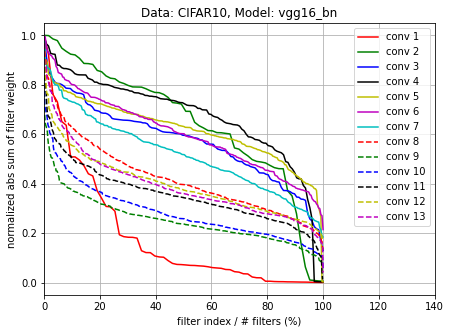

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,5))
conv_count = 0
for layer in network.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        # filter weight dimension info: out_ch, in_ch, k1, k2
        fw = layer.weight.data.cpu().numpy()
        
        # sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # normalize with maximum value
        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.title("Data: %s, Model: %s"%(args.data_set, args.vgg))        
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure1.png", dpi=150, bbox_inches='tight')
plt.show()        

## check: accuracy of the pruned network

In [ ]:
prune_step_ratio = 1/8
max_channel_ratio = 0.90 

prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']

## Check accuracy of the pruned network

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 09:25:30 2022: Test information, Data(s): 1.611, Forward(s): 0.211, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 09:25:30 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Streaming output truncated to the last 5000 lines.
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(24, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_s

## Plot accuracy graph

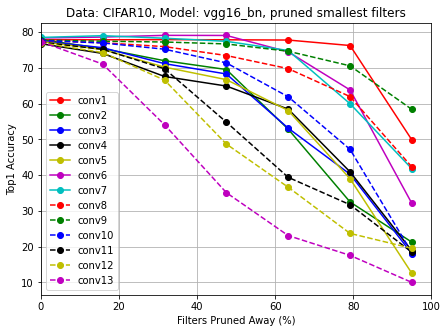

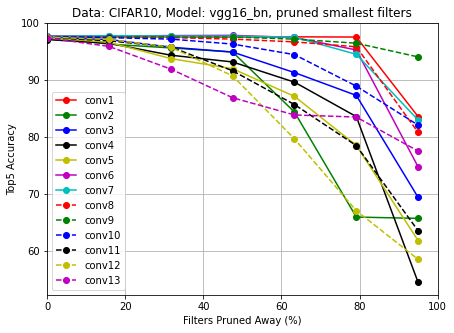

In [ ]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top5.png", dpi=150, bbox_inches='tight')
plt.show()      

## Check: Accuracy of retrained the pruned network

In [ ]:
args.retrain_flag = True
args.retrain_epoch = 10
args.independent_prune_flag = False
args.retrain_lr = 0.001

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 09:31:09 2022: Test information, Data(s): 1.691, Forward(s): 0.218, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 09:31:09 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Streaming output truncated to the last 5000 lines.
    (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (39): ReLU(inplace=True)
    (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (42): ReLU(inplace=True)
    (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2    

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

In [ ]:
for conv, channel in zip(prune_layers[0:1], prune_channels[0:1]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 18:48:28 2022: Test information, Data(s): 3.054, Forward(s): 0.520, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 18:48:28 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 18:48:31 2022: Epoch [0], Iteration [0/391/], Data(s): 0.064, Loss(s): 0.008, Forward(s): 0.659, Backward(s): 1.390, Top1: 82.031, Top5: 98.4375, Loss: 0.491
Mon Apr 25 18:48:49 2022: Epoch [0], Iteration [100/391/], Data(s): 0.063, Loss(s): 0.027, Forward(s): 0.013, Backward(s): 0.027, Top1: 87.570, Top5: 98.8707, Loss: 0.389
Mon Apr 25 18:49:07 2022: Epoch [0], Iteration [200/391/], Data(s): 0.064, Loss(s): 0.027, Forward(s): 0.009, Backward(s): 0.020, Top1: 88.036, Top5: 99.0050, Loss: 0.355
Mon Apr 25 18:49:25 2022: Epoch [0], Iteration [300/391/], Data(s): 0.065, Loss(s): 0.027, Forward(s): 0.008, Backward(s): 0.018, Top1: 88.455, Top5: 99.0397, Loss: 0.332
Mon Apr 25 18:49:43 2022: Epoch [1], Iteration [0/391/], Data(s): 0.084, Loss(s): 0.030, Forward(s): 0.007, Backward(s): 0.013, Top1: 89.062, Top5: 99.2188, Loss: 0.326
Mon Apr 25 18:50:00 2022: Epoch [1

In [ ]:
top1_accuracies

{'conv1': [90.0, 90.58, 91.01, 91.2, 91.33, 91.32, 91.25]}

In [ ]:
top5_accuracies

{'conv1': [99.25, 99.3, 99.32, 99.31, 99.28, 99.32, 99.29]}

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

In [ ]:
for conv, channel in zip(prune_layers[4:6], prune_channels[4:6]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 14:33:44 2022: Test information, Data(s): 2.768, Forward(s): 0.539, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 14:33:44 2022: conv5 Layer, 32 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 14:33:48 2022: Epoch [0], Iteration [0/391/], Data(s): 0.071, Loss(s): 0.012, Forward(s): 0.912, Backward(s): 1.528, Top1: 83.594, Top5: 99.2188, Loss: 0.542
Mon Apr 25 14:34:05 2022: Epoch [0], Iteration [100/391/], Data(s): 0.057, Loss(s): 0.028, Forward(s): 0.015, Backward(s): 0.029, Top1: 86.618, Top5: 98.8320, Loss: 0.414
Mon Apr 25 14:34:22 2022: Epoch [0], Iteration [200/391/], Data(s): 0.056, Loss(s): 0.028, Forward(s): 0.011, Backward(s): 0.021, Top1: 87.554, Top5: 98.9817, Loss: 0.354
Mon Apr 25 14:34:39 2022: Epoch [0], Iteration [300/391/], Data(s): 0.057, Loss(s): 0.028, Forward(s): 0.010, Backward(s): 0.019, Top1: 88.071, Top5: 99.0474, Loss: 0.337
Mon Apr 25 14:34:56 2022: Epoch [1], Iteration [0/391/], Data(s): 0.062, Loss(s): 0.032, Forward(s): 0.007, Backward(s): 0.013, Top1: 89.844, Top5: 99.2188, Loss: 0.320
Mon Apr 25 14:35:13 2022: Epoch [1

In [ ]:
top1_accuracies

{'conv5': [89.72, 90.54, 90.85, 91.05, 91.14, 90.72, 89.35],
 'conv6': [89.97, 90.5, 91.08, 90.98, 91.08, 90.89, 90.37]}

In [ ]:
top5_accuracies

{'conv5': [99.3, 99.29, 99.29, 99.34, 99.29, 99.37, 99.15],
 'conv6': [99.25, 99.34, 99.32, 99.32, 99.38, 99.37, 99.27]}

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

In [ ]:
for conv, channel in zip(prune_layers[3:4], prune_channels[3:4]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 18:25:25 2022: Test information, Data(s): 1.676, Forward(s): 0.210, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 18:25:25 2022: conv4 Layer, 16 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 18:25:26 2022: Epoch [0], Iteration [0/391/], Data(s): 0.040, Loss(s): 0.007, Forward(s): 0.041, Backward(s): 0.092, Top1: 89.062, Top5: 97.6562, Loss: 0.435
Mon Apr 25 18:25:34 2022: Epoch [0], Iteration [100/391/], Data(s): 0.036, Loss(s): 0.011, Forward(s): 0.003, Backward(s): 0.007, Top1: 86.904, Top5: 98.8320, Loss: 0.405
Mon Apr 25 18:25:42 2022: Epoch [0], Iteration [200/391/], Data(s): 0.035, Loss(s): 0.011, Forward(s): 0.003, Backward(s): 0.006, Top1: 87.702, Top5: 98.9817, Loss: 0.354
Mon Apr 25 18:25:50 2022: Epoch [0], Iteration [300/391/], Data(s): 0.035, Loss(s): 0.011, Forward(s): 0.003, Backward(s): 0.006, Top1: 88.201, Top5: 99.0942, Loss: 0.336
Mon Apr 25 18:25:58 2022: Epoch [1], Iteration [0/391/], Data(s): 0.059, Loss(s): 0.009, Forward(s): 0.005, Backward(s): 0.006, Top1: 90.625, Top5: 100.0000, Loss: 0.322
Mon Apr 25 18:26:06 2022: Epoch [

In [ ]:
for conv, channel in zip(prune_layers[10:11], prune_channels[10:11]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:47:11 2022: Test information, Data(s): 1.616, Forward(s): 0.210, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 17:47:11 2022: conv11 Layer, 65 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:47:12 2022: Epoch [0], Iteration [0/391/], Data(s): 0.038, Loss(s): 0.011, Forward(s): 0.003, Backward(s): 0.006, Top1: 89.062, Top5: 98.4375, Loss: 0.439
Mon Apr 25 17:47:20 2022: Epoch [0], Iteration [100/391/], Data(s): 0.034, Loss(s): 0.012, Forward(s): 0.003, Backward(s): 0.006, Top1: 87.214, Top5: 99.0408, Loss: 0.398
Mon Apr 25 17:47:28 2022: Epoch [0], Iteration [200/391/], Data(s): 0.034, Loss(s): 0.012, Forward(s): 0.003, Backward(s): 0.006, Top1: 87.838, Top5: 99.1177, Loss: 0.354
Mon Apr 25 17:47:36 2022: Epoch [0], Iteration [300/391/], Data(s): 0.034, Loss(s): 0.012, Forward(s): 0.003, Backward(s): 0.006, Top1: 88.203, Top5: 99.1435, Loss: 0.342
Mon Apr 25 17:47:43 2022: Epoch [1], Iteration [0/391/], Data(s): 0.052, Loss(s): 0.011, Forward(s): 0.003, Backward(s): 0.006, Top1: 94.531, Top5: 100.0000, Loss: 0.327
Mon Apr 25 17:47:51 2022: Epoch [

In [ ]:
for conv, channel in zip(prune_layers[11:12], prune_channels[11:12]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:10:02 2022: Test information, Data(s): 1.691, Forward(s): 0.217, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 17:10:02 2022: conv12 Layer, 65 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:10:03 2022: Epoch [0], Iteration [0/391/], Data(s): 0.039, Loss(s): 0.001, Forward(s): 0.067, Backward(s): 0.135, Top1: 82.031, Top5: 96.8750, Loss: 0.584
Mon Apr 25 17:10:11 2022: Epoch [0], Iteration [100/391/], Data(s): 0.036, Loss(s): 0.011, Forward(s): 0.004, Backward(s): 0.008, Top1: 87.020, Top5: 98.8707, Loss: 0.403
Mon Apr 25 17:10:19 2022: Epoch [0], Iteration [200/391/], Data(s): 0.036, Loss(s): 0.011, Forward(s): 0.003, Backward(s): 0.007, Top1: 87.924, Top5: 99.0322, Loss: 0.353
Mon Apr 25 17:10:28 2022: Epoch [0], Iteration [300/391/], Data(s): 0.036, Loss(s): 0.011, Forward(s): 0.003, Backward(s): 0.007, Top1: 88.390, Top5: 99.0812, Loss: 0.335
Mon Apr 25 17:10:35 2022: Epoch [1], Iteration [0/391/], Data(s): 0.065, Loss(s): 0.010, Forward(s): 0.004, Backward(s): 0.008, Top1: 89.844, Top5: 100.0000, Loss: 0.324
Mon Apr 25 17:10:44 2022: Epoch [

In [ ]:
for conv, channel in zip(prune_layers[12:], prune_channels[12:]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 16:24:15 2022: Test information, Data(s): 1.657, Forward(s): 0.213, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 16:24:15 2022: conv13 Layer, 65 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 16:24:17 2022: Epoch [0], Iteration [0/391/], Data(s): 0.042, Loss(s): 0.006, Forward(s): 0.373, Backward(s): 0.697, Top1: 81.250, Top5: 97.6562, Loss: 0.533
Mon Apr 25 16:24:25 2022: Epoch [0], Iteration [100/391/], Data(s): 0.035, Loss(s): 0.011, Forward(s): 0.007, Backward(s): 0.013, Top1: 86.603, Top5: 98.9403, Loss: 0.403
Mon Apr 25 16:24:33 2022: Epoch [0], Iteration [200/391/], Data(s): 0.035, Loss(s): 0.011, Forward(s): 0.005, Backward(s): 0.010, Top1: 87.749, Top5: 99.0944, Loss: 0.345
Mon Apr 25 16:24:41 2022: Epoch [0], Iteration [300/391/], Data(s): 0.035, Loss(s): 0.011, Forward(s): 0.004, Backward(s): 0.009, Top1: 88.289, Top5: 99.0994, Loss: 0.334
Mon Apr 25 16:24:49 2022: Epoch [1], Iteration [0/391/], Data(s): 0.041, Loss(s): 0.010, Forward(s): 0.004, Backward(s): 0.006, Top1: 91.406, Top5: 100.0000, Loss: 0.319
Mon Apr 25 16:24:57 2022: Epoch [

In [ ]:
top1_accuracies

{'conv11': [89.84, 90.73, 91.1, 91.27, 91.17, 91.28, 91.14],
 'conv12': [89.88, 90.67, 91.07, 91.28, 91.41, 91.37, 91.2],
 'conv13': [90.08, 90.66, 91.02, 91.33, 91.37, 91.47, 91.44],
 'conv4': [90.06, 90.46, 90.86, 90.61, 90.41, 90.21, 88.37]}

In [ ]:
top5_accuracies

{'conv11': [99.27, 99.31, 99.27, 99.3, 99.26, 99.23, 99.24],
 'conv12': [99.33, 99.31, 99.32, 99.34, 99.25, 99.26, 99.32],
 'conv13': [99.31, 99.32, 99.31, 99.25, 99.3, 99.25, 99.36],
 'conv4': [99.23, 99.29, 99.32, 99.33, 99.26, 99.38, 99.32]}

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

In [ ]:
for conv, channel in zip(prune_layers[1:2], prune_channels[1:2]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:08:52 2022: Test information, Data(s): 2.465, Forward(s): 0.465, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 17:08:52 2022: conv2 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(56, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:08:54 2022: Epoch [0], Iteration [0/391/], Data(s): 0.050, Loss(s): 0.009, Forward(s): 0.206, Backward(s): 0.396, Top1: 84.375, Top5: 97.6562, Loss: 0.547
Mon Apr 25 17:09:10 2022: Epoch [0], Iteration [100/391/], Data(s): 0.049, Loss(s): 0.028, Forward(s): 0.008, Backward(s): 0.016, Top1: 87.314, Top5: 98.7469, Loss: 0.397
Mon Apr 25 17:09:26 2022: Epoch [0], Iteration [200/391/], Data(s): 0.049, Loss(s): 0.029, Forward(s): 0.007, Backward(s): 0.014, Top1: 88.036, Top5: 98.9506, Loss: 0.356
Mon Apr 25 17:09:42 2022: Epoch [0], Iteration [300/391/], Data(s): 0.050, Loss(s): 0.029, Forward(s): 0.006, Backward(s): 0.013, Top1: 88.541, Top5: 99.0293, Loss: 0.330
Mon Apr 25 17:09:57 2022: Epoch [1], Iteration [0/391/], Data(s): 0.077, Loss(s): 0.029, Forward(s): 0.007, Backward(s): 0.012, Top1: 91.406, Top5: 100.0000, Loss: 0.326
Mon Apr 25 17:10:13 2022: Epoch [

In [ ]:
for conv, channel in zip(prune_layers[6:8], prune_channels[6:8]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 14:38:11 2022: Test information, Data(s): 2.533, Forward(s): 0.485, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 14:38:11 2022: conv7 Layer, 32 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 14:38:15 2022: Epoch [0], Iteration [0/391/], Data(s): 0.053, Loss(s): 0.009, Forward(s): 0.792, Backward(s): 1.483, Top1: 89.844, Top5: 99.2188, Loss: 0.306
Mon Apr 25 14:38:31 2022: Epoch [0], Iteration [100/391/], Data(s): 0.051, Loss(s): 0.029, Forward(s): 0.014, Backward(s): 0.027, Top1: 87.051, Top5: 98.7933, Loss: 0.410
Mon Apr 25 14:38:47 2022: Epoch [0], Iteration [200/391/], Data(s): 0.051, Loss(s): 0.029, Forward(s): 0.010, Backward(s): 0.019, Top1: 87.687, Top5: 98.9583, Loss: 0.356
Mon Apr 25 14:39:04 2022: Epoch [0], Iteration [300/391/], Data(s): 0.054, Loss(s): 0.028, Forward(s): 0.009, Backward(s): 0.017, Top1: 88.437, Top5: 99.0526, Loss: 0.324
Mon Apr 25 14:39:21 2022: Epoch [1], Iteration [0/391/], Data(s): 0.059, Loss(s): 0.033, Forward(s): 0.007, Backward(s): 0.012, Top1: 91.406, Top5: 99.2188, Loss: 0.308
Mon Apr 25 14:39:37 2022: Epoch [1

In [ ]:
top1_accuracies

{'conv2': [90.05, 90.57, 90.78, 91.04, 90.95, 90.51, 88.92],
 'conv7': [90.21, 90.68, 90.97, 91.12, 91.18, 90.88, 90.73],
 'conv8': [90.06, 90.74, 91.06, 91.27, 91.51, 91.57, 91.24]}

In [ ]:
top5_accuracies

{'conv2': [99.28, 99.26, 99.29, 99.28, 99.26, 99.32, 99.21],
 'conv7': [99.24, 99.31, 99.29, 99.32, 99.3, 99.26, 99.26],
 'conv8': [99.27, 99.34, 99.32, 99.33, 99.25, 99.23, 99.31]}

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

In [ ]:
for conv, channel in zip(prune_layers[2:3], prune_channels[2:3]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:43:27 2022: Test information, Data(s): 2.395, Forward(s): 0.454, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 17:43:27 2022: conv3 Layer, 16 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 17:43:29 2022: Epoch [0], Iteration [0/391/], Data(s): 0.059, Loss(s): 0.028, Forward(s): 0.107, Backward(s): 0.241, Top1: 93.750, Top5: 99.2188, Loss: 0.299
Mon Apr 25 17:43:49 2022: Epoch [0], Iteration [100/391/], Data(s): 0.052, Loss(s): 0.042, Forward(s): 0.007, Backward(s): 0.014, Top1: 86.920, Top5: 98.7933, Loss: 0.409
Mon Apr 25 17:44:09 2022: Epoch [0], Iteration [200/391/], Data(s): 0.051, Loss(s): 0.042, Forward(s): 0.006, Backward(s): 0.013, Top1: 87.655, Top5: 98.9933, Loss: 0.359
Mon Apr 25 17:44:29 2022: Epoch [0], Iteration [300/391/], Data(s): 0.050, Loss(s): 0.042, Forward(s): 0.006, Backward(s): 0.012, Top1: 88.141, Top5: 99.0786, Loss: 0.334
Mon Apr 25 17:44:48 2022: Epoch [1], Iteration [0/391/], Data(s): 0.071, Loss(s): 0.041, Forward(s): 0.006, Backward(s): 0.011, Top1: 89.062, Top5: 98.4375, Loss: 0.323
Mon Apr 25 17:45:08 2022: Epoch [1

In [ ]:
for conv, channel in zip(prune_layers[8:10], prune_channels[8:10]):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Mon Apr 25 14:43:11 2022: Test information, Data(s): 2.525, Forward(s): 0.498, Top1: 77.870, Top5: 97.560, 

Mon Apr 25 14:43:11 2022: conv9 Layer, 65 Channels pruned


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2

In [ ]:
top1_accuracies

{'conv10': [90.07, 90.8, 90.96, 91.26, 91.45, 91.34, 91.38],
 'conv3': [90.0, 90.57, 90.84, 90.92, 90.82, 90.72, 89.96],
 'conv9': [90.06, 90.53, 91.08, 91.28, 91.23, 91.37, 91.42]}

In [ ]:
top5_accuracies

{'conv10': [99.27, 99.3, 99.32, 99.31, 99.28, 99.33, 99.29],
 'conv3': [99.27, 99.26, 99.28, 99.26, 99.3, 99.35, 99.24],
 'conv9': [99.27, 99.3, 99.33, 99.35, 99.29, 99.34, 99.28]}

In [ ]:
# Final top1 and top5  accuracies

In [ ]:
top1_accuracies = {'conv10': [90.07, 90.8, 90.96, 91.26, 91.45, 91.34, 91.38],
 'conv3': [90.0, 90.57, 90.84, 90.92, 90.82, 90.72, 89.96],
 'conv9': [90.06, 90.53, 91.08, 91.28, 91.23, 91.37, 91.42],
 'conv2': [90.05, 90.57, 90.78, 91.04, 90.95, 90.51, 88.92],
 'conv7': [90.21, 90.68, 90.97, 91.12, 91.18, 90.88, 90.73],
 'conv8': [90.06, 90.74, 91.06, 91.27, 91.51, 91.57, 91.24],
 'conv11': [89.84, 90.73, 91.1, 91.27, 91.17, 91.28, 91.14],
 'conv12': [89.88, 90.67, 91.07, 91.28, 91.41, 91.37, 91.2],
 'conv13': [90.08, 90.66, 91.02, 91.33, 91.37, 91.47, 91.44],
 'conv4': [90.06, 90.46, 90.86, 90.61, 90.41, 90.21, 88.37],
 'conv5': [89.72, 90.54, 90.85, 91.05, 91.14, 90.72, 89.35],
 'conv6': [89.97, 90.5, 91.08, 90.98, 91.08, 90.89, 90.37],
 'conv1': [90.0, 90.58, 91.01, 91.2, 91.33, 91.32, 91.25]}

In [ ]:
top5_accuracies = {'conv10': [99.27, 99.3, 99.32, 99.31, 99.28, 99.33, 99.29],
 'conv3': [99.27, 99.26, 99.28, 99.26, 99.3, 99.35, 99.24],
 'conv9': [99.27, 99.3, 99.33, 99.35, 99.29, 99.34, 99.28],
 'conv2': [99.28, 99.26, 99.29, 99.28, 99.26, 99.32, 99.21],
 'conv7': [99.24, 99.31, 99.29, 99.32, 99.3, 99.26, 99.26],
 'conv8': [99.27, 99.34, 99.32, 99.33, 99.25, 99.23, 99.31],
 'conv11': [99.27, 99.31, 99.27, 99.3, 99.26, 99.23, 99.24],
 'conv12': [99.33, 99.31, 99.32, 99.34, 99.25, 99.26, 99.32],
 'conv13': [99.31, 99.32, 99.31, 99.25, 99.3, 99.25, 99.36],
 'conv4': [99.23, 99.29, 99.32, 99.33, 99.26, 99.38, 99.32],
 'conv5': [99.3, 99.29, 99.29, 99.34, 99.29, 99.37, 99.15],
 'conv6': [99.25, 99.34, 99.32, 99.32, 99.38, 99.37, 99.27],
 'conv1': [99.25, 99.3, 99.32, 99.31, 99.28, 99.32, 99.29]}

## Plot the accuracy graph

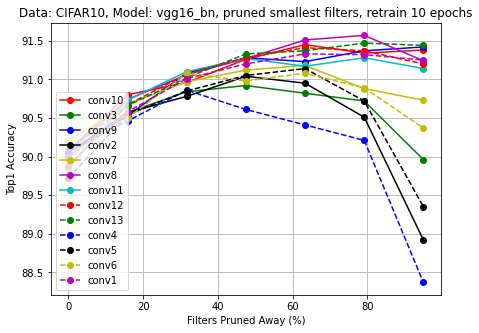

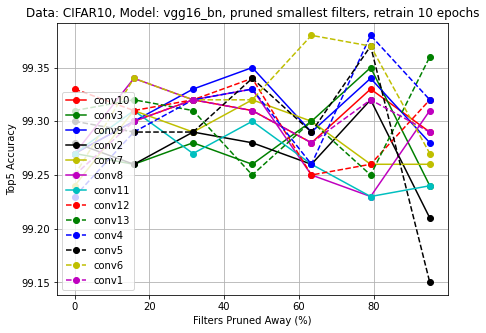

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
# plt.xlim(0, 100)
plt.savefig("figure3_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
# plt.xlim(0, 100)
# plt.ylim(bottom= 0)
plt.savefig("figure3_top5.png", dpi=150, bbox_inches='tight')
plt.show()             